# Step 1: Import Library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'2.6.0+cu124'

# Step 2 : Set up GPU

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

# Step 3 : Hyperparameter

In [69]:
BATCH_SIZE = 128
EPOCHS = 60 # BEFORE 25
LEARNING_RATE = 3e-4
PATCH_SIZE = 4 # 4X4
NUM_CLASSES = 10 # 10 Classes airplane , bus etc
IMAGE_SIZE = 32
CHANNELS = 3
EMBED_DIM = 256
NUM_HEADS = 8  # Number of multi head attentions
DEPTH = 8 # before 6 TRANSFORMERS
MLP_DIM = 768
DROP_RATE = 0.1
WEIGHT_DECAY = 0.01 # ADDED FOR AUG

# step 4 : Image Transformation

In [70]:
# before augmentation
before_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5) , std = (0.5)), # helps to make model converge faster # 2. helps to make numerical computations stable

])

#after augmentation
after_transform = transforms.Compose([
    transforms.RandomCrop(32 , padding = 4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

## Step 5 : Getting Dataset

In [71]:
train_dataset = datasets.CIFAR10(root ="data/train" , download=True , transform = after_transform , train=True)

100%|██████████| 170M/170M [00:04<00:00, 35.2MB/s]


In [72]:
test_dataset = datasets.CIFAR10(root ="data/test" , download=True , transform = after_transform , train=False)

100%|██████████| 170M/170M [00:03<00:00, 48.5MB/s]


In [73]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/train
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [74]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/test
    Split: Test
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

# Step 6 : Converting pytorchDatasets into DataLoaders

DataLoader converts it into iterable batches or (mini-batches)
1. More computationally efficient(i.e not able to store 50k data in on loop in ram to divide it into batches of 128 images)

2. It gives our neural network to update its gradient in each epoch


In [75]:
train_loader = DataLoader(dataset = train_dataset , batch_size=BATCH_SIZE , shuffle = True , pin_memory = True)
test_loader = DataLoader(dataset = test_dataset , batch_size=BATCH_SIZE , shuffle = False, pin_memory = True)

In [76]:
# Let's check out what we've created
print(f"DataLoader: {train_loader, test_loader}")
print(f"Length of train_loader: {len(train_loader)} batches of {BATCH_SIZE}...")
print(f"Length of test_loader: {len(test_loader)} batches of {BATCH_SIZE}...")

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x7c90c84cba90>, <torch.utils.data.dataloader.DataLoader object at 0x7c90c84ca210>)
Length of train_loader: 391 batches of 128...
Length of test_loader: 79 batches of 128...


# Step 7 : Building Vision Transfomer model From Scratch

In [77]:
class Patch_Embedding(nn.Module):
  def __init__(self ,image_size ,patch_size ,in_channels , embed_dim ):
    super().__init__()
    self.patch_size = patch_size
    self.projection = nn.Conv2d(
        in_channels = in_channels,
        out_channels = embed_dim,
        kernel_size = patch_size,
        stride = patch_size,
    )

    num_patches = (image_size // patch_size) ** 2
    self.pos_embedding = nn.Parameter(torch.randn(1, 1 + num_patches , embed_dim))
    self.cls_token = nn.Parameter(torch.randn(1 , 1, embed_dim))


  def forward(self , x : torch.Tensor):
    B = x.size(0)
    x = self.projection(x) # ( B , E , H/P , W/P)
    x = x.flatten(2).transpose(1,2) #( B, N, E)

    cls_tokens = self.cls_token.expand(B, -1, -1)
    x = torch.cat((cls_tokens, x), dim=1)
    x = x + self.pos_embedding

    return x

In [78]:
class MLP(nn.Module):
  def __init__(self , in_features , hidden_features , dropout_rate ):
    super().__init__()

    self.fc1 = nn.Linear(in_features= in_features , out_features = hidden_features)

    self.fc2 = nn.Linear(in_features = hidden_features , out_features= in_features)

    self.dropout = nn.Dropout(p = dropout_rate)

  def forward(self , x):
    x = self.fc1(x)
    x = F.gelu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.dropout(x)

    return x

In [79]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self , embed_dim , num_heads , mlp_dim , dropout_rate):
    super().__init__()

    self.norm1 = nn.LayerNorm(embed_dim)

    self.attention = nn.MultiheadAttention(embed_dim , num_heads=num_heads , dropout=dropout_rate , batch_first = True)

    self.norm2 = nn.LayerNorm(embed_dim)

    self.mlp = MLP(embed_dim , mlp_dim , dropout_rate)

  def forward(self , x):
    residual = x
    x = self.norm1(x)
    x , _ = self.attention(x , x , x) # or  x = self.attention(x , x , x)[0]
    x = x + residual

    residual = x
    x = self.norm2(x)
    x = self.mlp(x)

    return x

In [80]:
class VisionTransformer(nn.Module):
  def __init__(self , image_size , patch_size , in_channels , num_classes , embed_dim , num_heads , depth , mlp_dim , dropout_rate):
    super().__init__()

    self.patch_embed = Patch_Embedding(image_size=image_size , patch_size=patch_size , in_channels=in_channels , embed_dim=embed_dim)

    self.encoder = nn.Sequential(*[
        TransformerEncoderLayer(embed_dim , num_heads , mlp_dim , dropout_rate)
        for _ in range(depth)
    ])


    self.norm = nn.LayerNorm(embed_dim)

    self.head = nn.Linear(embed_dim , num_classes)

  def forward(self, x):
    x = self.patch_embed(x)
    x = self.encoder(x)
    x = self.norm(x)
    cls_token = x[:, 0]
    x = self.head(cls_token)

    return x


# Model Instantiation

In [81]:
model = VisionTransformer(
    IMAGE_SIZE,
    PATCH_SIZE,
    CHANNELS,
    NUM_CLASSES,
    EMBED_DIM,
    NUM_HEADS,  # 8
    DEPTH,      # 6
    MLP_DIM,
    DROP_RATE
).to(device)

In [82]:
model

VisionTransformer(
  (patch_embed): Patch_Embedding(
    (projection): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=768, bias=True)
        (fc2): Linear(in_features=768, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)

# Step 8 : loss function and optimizer

In [83]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Step 9 : Train Model

In [84]:
def train(model , loader , optimizer , criterion ):
  # set the mode of the model to the training mode
  model.train()

  total_loss , correct_predictions = 0 , 0

  for x , y in loader:
    x , y = x.to(device) , y.to(device)

    optimizer.zero_grad()
    # forward
    out = model(x)

    #loss
    loss = criterion(out , y)

    #optimizer
    loss.backward()
    optimizer.step()


    total_loss += loss.item() * x.size(0)

    correct_predictions += (out.argmax(1) == y).sum().item()

  return total_loss / len(loader.dataset) , correct_predictions / len(loader.dataset)

In [85]:
def evaluate(model , loader):
  model.eval()

  correct_predictions =   0

  with torch.no_grad():
    for x , y in loader:
      x , y = x.to(device) , y.to(device)

      out = model(x)

      loss = criterion(out , y)

      correct_predictions += (out.argmax(1) == y).sum().item()

  return correct_predictions / len(loader.dataset)

# Model training

In [86]:
from tqdm.auto import tqdm
train_accuracies , test_accuracies = [] , []


for epoch in tqdm(range(EPOCHS)):
  train_loss , train_acc = train(model , train_loader , optimizer , criterion)

  test_acc = evaluate(model , test_loader)

  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)

  print(f"Epoch: {epoch+1}/{EPOCHS}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}%, Test acc: {test_acc:.4f}")

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 1/60, Train loss: 2.1611, Train acc: 0.1888%, Test acc: 0.2181
Epoch: 2/60, Train loss: 2.0761, Train acc: 0.2238%, Test acc: 0.2482
Epoch: 3/60, Train loss: 2.0205, Train acc: 0.2491%, Test acc: 0.2761
Epoch: 4/60, Train loss: 1.9584, Train acc: 0.2829%, Test acc: 0.3111
Epoch: 5/60, Train loss: 1.9246, Train acc: 0.3070%, Test acc: 0.3168
Epoch: 6/60, Train loss: 1.8819, Train acc: 0.3289%, Test acc: 0.3588
Epoch: 7/60, Train loss: 1.8469, Train acc: 0.3557%, Test acc: 0.3691
Epoch: 8/60, Train loss: 1.8259, Train acc: 0.3672%, Test acc: 0.3860
Epoch: 9/60, Train loss: 1.8127, Train acc: 0.3732%, Test acc: 0.3907
Epoch: 10/60, Train loss: 1.7863, Train acc: 0.3858%, Test acc: 0.4090
Epoch: 11/60, Train loss: 1.7775, Train acc: 0.3921%, Test acc: 0.4112
Epoch: 12/60, Train loss: 1.7558, Train acc: 0.4059%, Test acc: 0.4221
Epoch: 13/60, Train loss: 1.7420, Train acc: 0.4093%, Test acc: 0.4193
Epoch: 14/60, Train loss: 1.7305, Train acc: 0.4214%, Test acc: 0.4449
Epoch: 15/60, T

In [87]:
train_accuracies

[0.1888,
 0.22382,
 0.24908,
 0.2829,
 0.30698,
 0.32888,
 0.35574,
 0.36722,
 0.37316,
 0.3858,
 0.3921,
 0.40588,
 0.4093,
 0.42136,
 0.42712,
 0.4352,
 0.43886,
 0.44428,
 0.44956,
 0.45692,
 0.46254,
 0.4674,
 0.46978,
 0.47702,
 0.47952,
 0.48374,
 0.48926,
 0.49358,
 0.49684,
 0.4998,
 0.50552,
 0.51348,
 0.51658,
 0.5193,
 0.5221,
 0.52646,
 0.53444,
 0.53532,
 0.53798,
 0.54068,
 0.54724,
 0.54862,
 0.55688,
 0.56042,
 0.56136,
 0.5667,
 0.57132,
 0.5746,
 0.5799,
 0.5832,
 0.58436,
 0.58556,
 0.59454,
 0.59734,
 0.60288,
 0.60218,
 0.60776,
 0.61348,
 0.61136,
 0.616]

In [88]:
test_accuracies

[0.2181,
 0.2482,
 0.2761,
 0.3111,
 0.3168,
 0.3588,
 0.3691,
 0.386,
 0.3907,
 0.409,
 0.4112,
 0.4221,
 0.4193,
 0.4449,
 0.4405,
 0.4465,
 0.4593,
 0.4557,
 0.4562,
 0.4691,
 0.4825,
 0.4915,
 0.467,
 0.4954,
 0.4777,
 0.497,
 0.4965,
 0.511,
 0.5097,
 0.509,
 0.5086,
 0.5173,
 0.5177,
 0.5247,
 0.5164,
 0.5407,
 0.5243,
 0.5325,
 0.5495,
 0.5536,
 0.5508,
 0.5526,
 0.5526,
 0.5563,
 0.5668,
 0.5652,
 0.5718,
 0.5798,
 0.5785,
 0.5744,
 0.5822,
 0.5873,
 0.5896,
 0.5994,
 0.6041,
 0.6097,
 0.6035,
 0.6046,
 0.6074,
 0.6177]

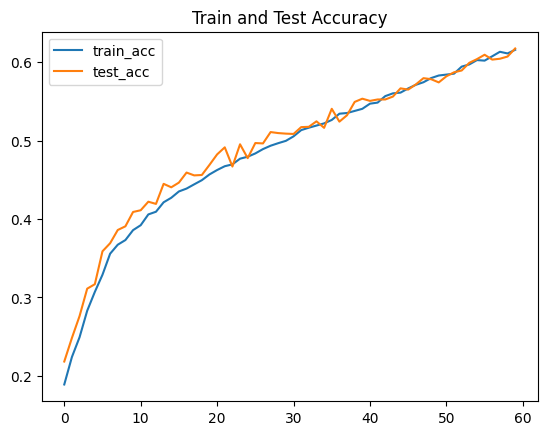

In [89]:
plt.plot(train_accuracies , label = "train_acc")
plt.plot(test_accuracies , label = "test_acc")
plt.legend()
plt.title("Train and Test Accuracy")
plt.show()

# Prediction

In [90]:
import random

In [91]:
def predict_plot_grid(model , dataset , classes , grid_size):
  model.eval()

  fig , axes = plt.subplots(grid_size , grid_size , figsize = (9 , 9))
  for i in range(grid_size):
    for j in range(grid_size):
      idx = random.randint(0 , len(dataset) - 1)
      img , true_label = dataset[idx]
      input_tensor = img.unsqueeze(0).to(device)

      with torch.inference_mode():
        output = model(input_tensor)

        _ , predicted = torch.max(output.data , 1)

      img = img / 2 + 0.5 # Unormalize our images to be able to plot them with matplotlib
      numpy_img = img.cpu().numpy() # numpy expects the image on cpu
      axes[i , j].imshow(np.transpose(numpy_img , (1 , 2 ,0)))

      truth = classes[true_label] == classes[predicted.item()]
      if truth:
        color = "g"
      else:
        color = "r"

      axes[i, j].set_title(f"Truth: {classes[true_label]}\n, Predicted: {classes[predicted.item()]}", fontsize=10, c=color)
      axes[i, j].axis("off")
  plt.tight_layout()
  plt.show()


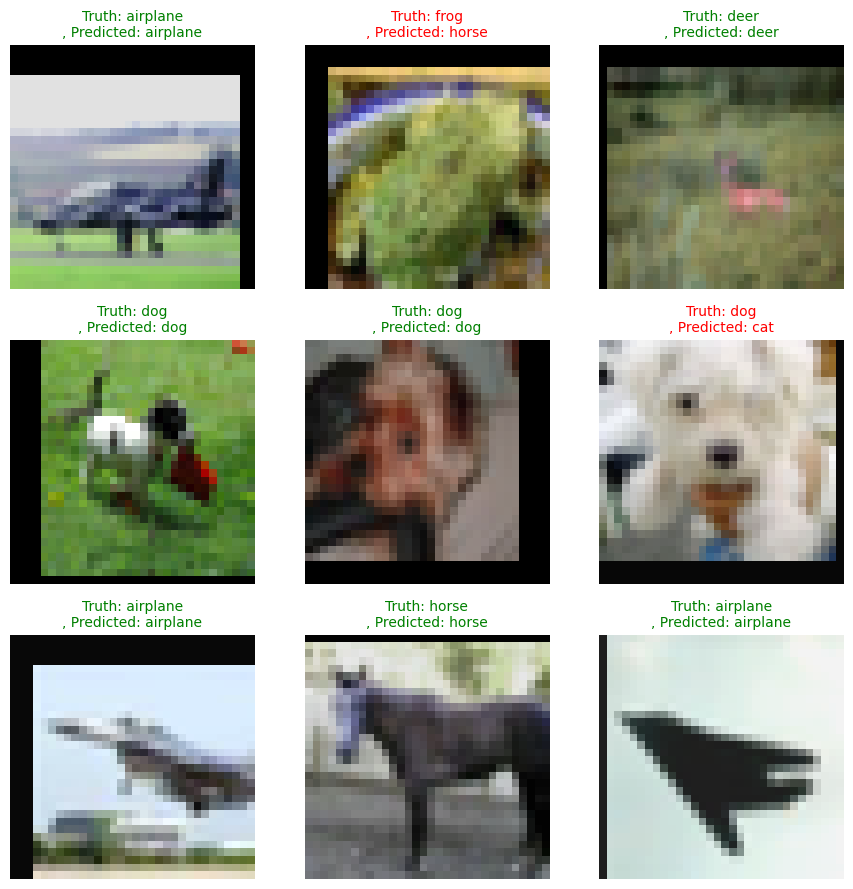

In [97]:
predict_plot_grid(model , test_dataset , train_dataset.classes , 3)

# Save model Before Augmentation

In [93]:
import os

# ===============================
# 1. Save model parameters only (state_dict)
# ===============================
state_dict_dir = "saved_models/state_dict_only"
os.makedirs(state_dict_dir, exist_ok=True)

state_dict_path = os.path.join(state_dict_dir, "model_weights.pth")
torch.save(model.state_dict(), state_dict_path)
print(f"Saved model weights (state_dict) to: {state_dict_path}")

# ===============================
# 2. Save full model (architecture + parameters)
# ===============================
full_model_dir = "saved_models/full_model"
os.makedirs(full_model_dir, exist_ok=True)

full_model_path = os.path.join(full_model_dir, "complete_model.pth")
torch.save(model, full_model_path)
print(f"Saved full model to: {full_model_path}")

Saved model weights (state_dict) to: saved_models/state_dict_only/model_weights.pth
Saved full model to: saved_models/full_model/complete_model.pth


# Save after Augmentation

In [94]:
import os

# ===============================
# 1. Save model parameters only (state_dict)
# ===============================
state_dict_dir = "best_models/state_dict_only"
os.makedirs(state_dict_dir, exist_ok=True)

state_dict_path = os.path.join(state_dict_dir, "model_weights.pth")
torch.save(model.state_dict(), state_dict_path)
print(f"Saved model weights (state_dict) to: {state_dict_path}")

# ===============================
# 2. Save full model (architecture + parameters)
# ===============================
full_model_dir = "best_models/full_model"
os.makedirs(full_model_dir, exist_ok=True)

full_model_path = os.path.join(full_model_dir, "complete_model.pth")
torch.save(model, full_model_path)
print(f"Saved full model to: {full_model_path}")

Saved model weights (state_dict) to: best_models/state_dict_only/model_weights.pth
Saved full model to: best_models/full_model/complete_model.pth


In [98]:
train_accuracies[-1]

0.616

In [99]:
test_accuracies[-1]

0.6177